# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator

# magic word for producing visualizations in notebook
%matplotlib inline


from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [50]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).


In [51]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [52]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


## Comparison and Convertion to NaN

To convert the missing or unknown data to NaN in the next section, I need to compare the values in each 
column in the azdias dataset with the corresponding "missing_or_unknown" in feat_info. But the current datatype in
feat_info appears to be string while the azdias dataset has either int or float. So, for effective comparison
and replacement, they need to be of same data type.

In [53]:
# Identify missing or unknown data values and convert them to NaNs.

# note down the total missisng values
print ('total missing values in azdias data set before NaN conversion :' , azdias.isnull().sum().sum())

#browse thru feat_info missing/unknown column, convert to float and use that to compare
#each column in the azdias and convert the matching rows to NaN
for index in feat_info.index:
    #get rid of the square braces
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    #print (feat_info.loc[index,'missing_or_unknown'])
    #parse and convert the individual values in missing_or_unknown array into float
    for val in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][val] = float(feat_info.loc[index,'missing_or_unknown'][val])
        except:
            continue
    #print (feat_info.loc[index,'missing_or_unknown'])
    #compare with the corresponding column in azdias and replace matching rows with NaN
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)
    
# recalculate the total missisng values
print ('total missing values in azdias data set after NaN conversion:' , azdias.isnull().sum().sum())

display (azdias.head (n=10))

total missing values in azdias data set before NaN conversion : 4896838
total missing values in azdias data set after NaN conversion: 8373929


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


## Observation about Missing/Unknown Values 


All valid values of missing/unknown category converted to NaNs. With the step, the total missing values are about 8.3M. While this is a very big portion, given the main dataset has 75M data points overall, by proportion its just over 10% and I think it aligns with real life situation data sets.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [54]:
azdias.shape

(891221, 85)

In [55]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
cols_with_missing_vals = azdias.isnull().sum()
#calcualte the missing val % of each column
cols_with_missing_vals  = cols_with_missing_vals [cols_with_missing_vals> 0]/(azdias.shape[0]) * 100
cols_with_missing_vals.sort_values(inplace=True)
cols_with_missing_vals

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

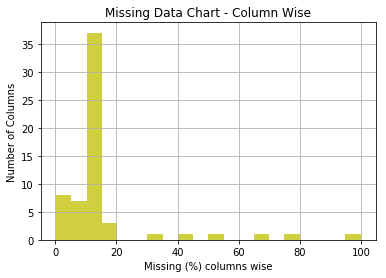

In [56]:
# Investigate patterns in the amount of missing data in each column.
#missing percentage plotting
plt.hist(cols_with_missing_vals, bins=20, facecolor='y', alpha=0.75)
plt.xlabel('Missing (%) columns wise')
plt.ylabel('Number of Columns')
plt.title('Missing Data Chart - Column Wise')
plt.grid(True)
plt.show()

In [57]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# identify columns with > 18% missing values
cols_with_high_missing_vals = [col for col in azdias.columns if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 18]
print(cols_with_high_missing_vals)


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [58]:
#drop the identified data set
for col in cols_with_high_missing_vals:
    azdias.drop(col, axis=1, inplace=True)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Though there are more than 10% of data missing overall in the azdias dataset, they are more concentrated in a few columns as per the % calcualted and the plotted chart. I think this is good because those columns stand out as outliers. With so much missing values, I think those features cannot actively contribute or have any meaningful impact on the segment classtification logic of the model anyway. Based on the calculated % of missing values, all columns have < 18% data missing except for 6 columns. One column in this 6 has 99% missing data. So, I idenfitied the columns with > 18% missing data and removed them. The columns removed are ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']. After this activity, I am left with 79 columns for further processing.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [59]:
# How much data is missing in each row of the dataset?
rows_with_missing_vals = azdias.isnull().sum(axis=1)
rows_with_missing_vals.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [60]:
rows_with_missing_vals = rows_with_missing_vals[rows_with_missing_vals > 0]/(len(azdias.columns)) * 100
rows_with_missing_vals.sort_values(inplace=True)
#rows_with_missing_vals

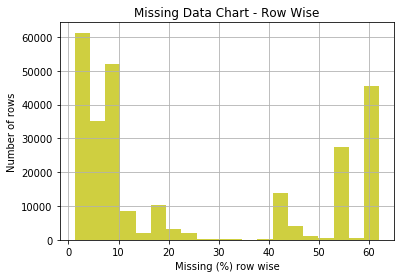

In [61]:
#plot the missing rows %
plt.hist(rows_with_missing_vals, bins=20, facecolor='y', alpha=0.75)
plt.xlabel('Missing (%) row wise')
plt.ylabel('Number of rows')
plt.title('Missing Data Chart - Row Wise')
plt.grid(True)
plt.show()

In [62]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# 75% of rows have 3 or less missing values, so divide the data set with rows < or > 3 missing values

rows_with_low_missing_values = azdias[azdias.isnull().sum(axis=1) <= 3].reset_index(drop=True)
rows_with_high_missing_values = azdias[azdias.isnull().sum(axis=1) > 3].reset_index(drop=True)

In [63]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def draw_countplot(cols,plot_num):
    fig, ax = plt.subplots(plot_num,2, figsize=(15, 25))
    fig.subplots_adjust(hspace =1 , wspace=.1)
    ax = ax.ravel()
    for i in range(plot_num):
        sns.countplot(rows_with_low_missing_values[cols[i]], ax=ax[i*2])
        ax[i*2].set_title('rows_with_low_missing_values')
        
        sns.countplot(rows_with_high_missing_values[cols[i]], ax=ax[i*2+1])
        ax[i*2+1].set_title('rows_with_high_missing_values')

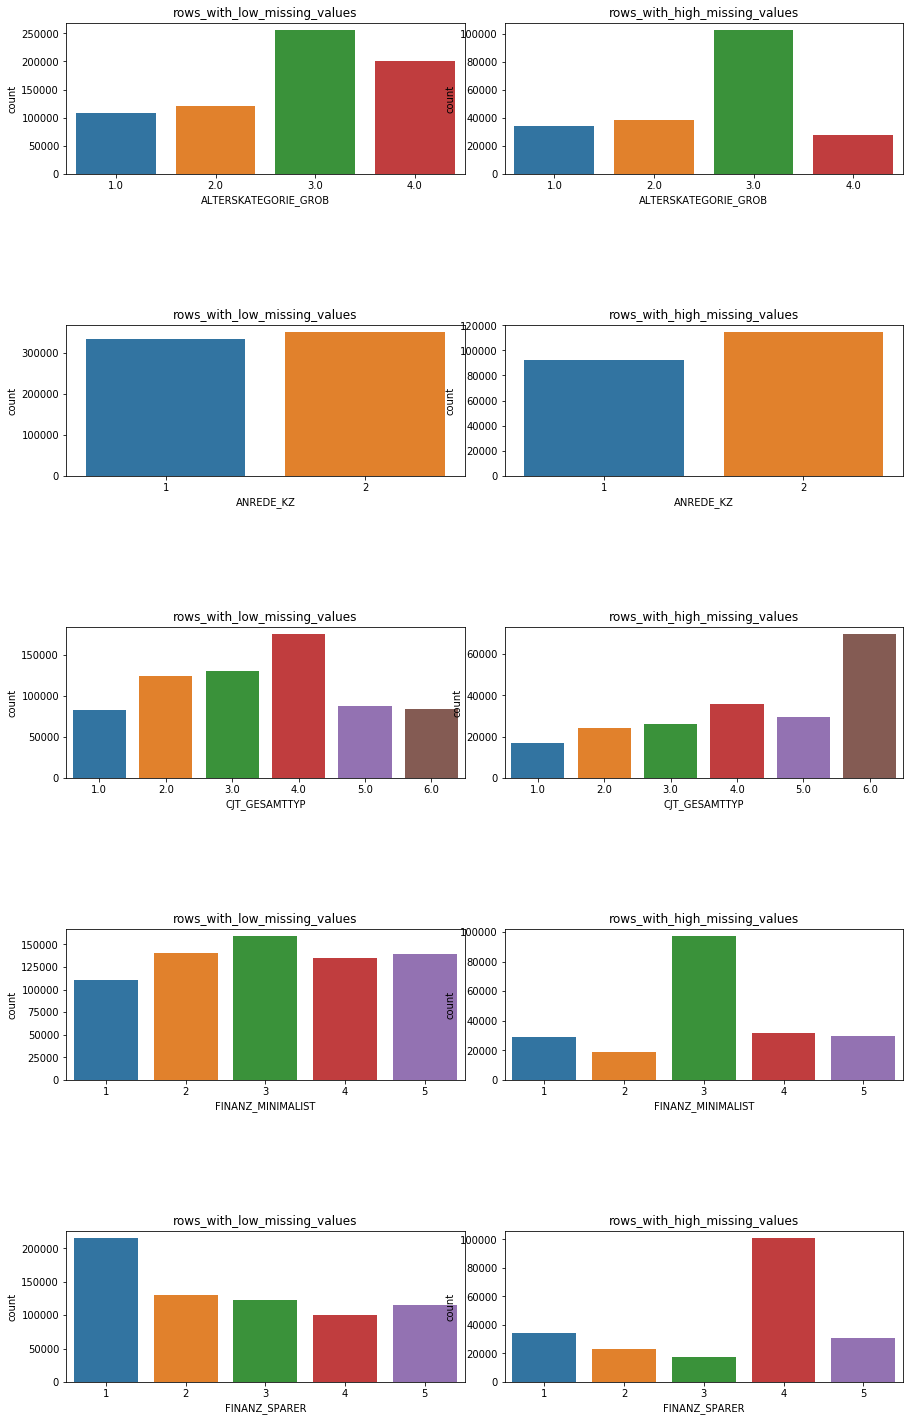

In [64]:
#plot atleast 5 columns from both subsets
draw_countplot(rows_with_low_missing_values.columns,5)

In [65]:
# per the recommendation, drop data with few or no missing values based on the threshild
#azdias.dropna(inplace=True)
row_wise_missing_count = azdias.apply(lambda x: len(azdias.columns) - x.count(), axis=1)
azdias = azdias.loc[row_wise_missing_count.values <= 3, :]
azdias.shape

(684502, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row



75% of rows have 3 or less missing values, so I divided the data set into two subsets, one with < 3 missing values and the other with > 3 missing values. From the plotted charts, the distribution looks similar for both subsets for some columns while thyey differ to a large extent in some columns. For instance, ANREDE_KZ and ALTERSKATEGORIE_GROB to some extent has similar distribution. For the rest of the plotted columns, the distribution varies significantly.  Though I feel dropping the rows with lots of missing data might have an effect on the model fucntionality, I went and dropped the rows that had > 3 missing value counts.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [66]:
# How many features are there of each data type?
# Drop the outlier columns from feature data set
feat_info = feat_info[~feat_info.attribute.isin(cols_with_high_missing_vals)]

feat_info.type.value_counts()


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [67]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# extract the categorical variables and find which ones have binary values
categorical_variables = feat_info.query('type == "categorical"').attribute
categorical_and_binary_variables_noEncode= []
categorical_and_binary_variables_encode= []
categorical_and_non_binary_variables= []
for col in categorical_variables:
    value_count = azdias[col].value_counts()
    if len(value_count) ==2:
        if azdias[col].dtypes == object:
            categorical_and_binary_variables_encode.append(col)
        else:
            categorical_and_binary_variables_noEncode.append(col)
    else:
        categorical_and_non_binary_variables.append(col)
print('# Categorical features with Binary values that do not need encoding:', categorical_and_binary_variables_noEncode)
print('# Categorical features with Binary values that need encoding:', categorical_and_binary_variables_encode)
print('# Categorical features with non-binary values:', categorical_and_non_binary_variables)

# Categorical features with Binary values that do not need encoding: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
# Categorical features with Binary values that need encoding: ['OST_WEST_KZ']
# Categorical features with non-binary values: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [68]:
# Re-encode categorical variable(s) to be kept in the analysis.
print('before encding: ', azdias['OST_WEST_KZ'].value_counts())
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda x: 0 if x == 'O'
                                                                else 1 if x == 'W'
                                                                else x)
print('after encding: ', azdias['OST_WEST_KZ'].value_counts())

before encding:  W    534902
O    149600
Name: OST_WEST_KZ, dtype: int64
after encding:  1    534902
0    149600
Name: OST_WEST_KZ, dtype: int64


In [69]:
#per the recommendation drop categorical columns with more than 2 values
azdias.drop(categorical_and_non_binary_variables, axis=1, inplace=True)
azdias.shape

(684502, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

 Out of 18 categorical features, 5 were identified to have binary features. Out of this 5, one had non-numerical values and it was re-encoded. The rest of the 13 multi-level features were dropped based on the recommendation above. Depending on the results of further sections in this project, I might have to revisit this decision.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [70]:
mixed_variables = feat_info.query('type == "mixed"').attribute
mixed_variables

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [71]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()
#indicators that tell mainstream or avantgarde
mainstream_indicator = [1,3,5,8,10,12,14]
avantgarde_indicator = [2,4,6,7,9,11,13,15]
#two rows per decade except for 80s, one for mainstream and another for avantgrade according to data dictionary. 
decade_40s = [1,2]
decade_50s = [3,4]
decade_60s = [5,6,7]
decade_70s = [8,9]
decade_80s = [10,11,12,13]
decade_90s = [14,15]
#one new feature variable that indicates mainstream vs avantgarde
azdias['MAINSTREAM_AVANTGARDE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in avantgarde_indicator
                                                                                    else 2 if x in mainstream_indicator
                                                                                    else 0)
#second new feature variable that indicates the decade  
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 40 if x in decade_40s
                                                                      else 50 if x in decade_50s
                                                                      else 60 if x in decade_60s
                                                                      else 70 if x in decade_70s
                                                                      else 80 if x in decade_80s
                                                                      else 90 if x in decade_90s
                                                                      else 0)


In [72]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#azdias['CAMEO_INTL_2015'].value_counts()

#per the data dictionary, the first digit in the value seem to indicate financial status (eg: wealthy,
#prosperous,comfortabl etc) and the second digit indicates the type of household. 

#creating first new feature based on financial status
azdias['FINANCIAL_STATUS'] = azdias['CAMEO_INTL_2015'].apply(lambda x: x[0] if not pd.isnull(x) else x)
#creating second new feature based on family type    
azdias['FAMILY_TYPE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: x[1] if not pd.isnull(x) else x)
#azdias['FINANCIAL_STATUS'].value_counts()
#azdias['FAMILY_TYPE'].value_counts()

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this section, 6 mixed type feartures were identified. Out of 6, two features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' were regnineered into seprate fatures capturing the original essence of the feature. Per the data dictionary, values of PRAEGENDE_JUGENDJAHRE indicated mainstream or avantgarde and the decade. So, that feature was broken into MAINSTREAM_AVANTGARDE and DECADE. Per the recommendation, as there aren't enough levels to disentangle east from west, it was dropped. Likewise, I re-encoded 'CAMEO_INTL_2015' into two features: 'FINANCIAL_STATUS' and 'FAMILY_TYPE' based on the tens and ones digits in the original value, as the first digit in the value seem to indicate financial status (eg: wealthy,prosperous,comfortabl etc) and the second digit indicates the type of household.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [73]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [74]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#now that the two new features are created based on the original feature, drop the original ones and the rest of the mixed features
azdias.drop(mixed_variables, axis=1, inplace=True)
azdias.shape

(684502, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [75]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    #browse thru feat_info missing/unknown column, convert to float and use that to compare
    #each column in the df and convert the matching rows to NaN
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    for index in feat_info.index:
        #get rid of the square braces
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        #print (feat_info.loc[index,'missing_or_unknown'])
        #parse and convert the individual values in missing_or_unknown array into float
        for val in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][val] = float(feat_info.loc[index,'missing_or_unknown'][val])
            except:
                continue
        #print (feat_info.loc[index,'missing_or_unknown'])
        #compare with the corresponding column in azdias and replace matching rows with NaN
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

    # remove selected columns and rows, ...define variables
    outlier_features_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    missing_val_row_threshold = 3
    categorical_features_to_drop = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
                                  'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                                  'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 
                                  'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    mixed_fearures_to_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE',
                            'WOHNLAGE','CAMEO_INTL_2015','PLZ8_BAUMAX']
    
    #drop outlier features
    df = df.drop(outlier_features_to_drop, axis=1)
    
    #drop rows with high missing values
    row_wise_missing_count = df.apply(lambda x: len(df.columns) - x.count(), axis=1)
    df = df.loc[row_wise_missing_count.values <= missing_val_row_threshold, :]
    
    #drop categorical features with non-binary values
    df = df.drop(categorical_features_to_drop, axis=1)
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 0 if x == 'O'
                                                     else 1 if x == 'W'
                                                     else x)
    
    #engineer new features from PRAEGENDE_JUGENDJAHRE
    mainstream_indicator = [1,3,5,8,10,12,14]
    avantgarde_indicator = [2,4,6,7,9,11,13,15]
    #two rows per decade except for 80s, one for mainstream and another for avantgrade according to data dictionary. 
    decade_40s = [1,2]
    decade_50s = [3,4]
    decade_60s = [5,6,7]
    decade_70s = [8,9]
    decade_80s = [10,11,12,13]
    decade_90s = [14,15]
    #one new feature variable that indicates mainstream vs avantgarde
    df['MAINSTREAM_AVANTGARDE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in avantgarde_indicator
                                                                                else 2 if x in mainstream_indicator
                                                                                else 0)
    #second new feature variable that indicates the decade  
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 40 if x in decade_40s
                                                                  else 50 if x in decade_50s
                                                                  else 60 if x in decade_60s
                                                                  else 70 if x in decade_70s
                                                                  else 80 if x in decade_80s
                                                                  else 90 if x in decade_90s
                                                                  else 0)
    
    
     #engineer new features from CAMEO_INTL_2015
    df['FINANCIAL_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: x[0] if not pd.isnull(x) else x)
    #creating second new feature based on family type    
    df['FAMILY_TYPE'] = df['CAMEO_INTL_2015'].apply(lambda x: x[1] if not pd.isnull(x) else x)
    
    # Return the cleaned dataframe.
    #drop mixed features with non-binary values
    df = df.drop(mixed_fearures_to_drop, axis=1)
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [76]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer()
azdias_imputed = imputer.fit_transform(azdias)

In [77]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)
azdias_ready_for_PCA = pd.DataFrame(azdias_scaled, columns = azdias.columns)
azdias_ready_for_PCA.shape

(684502, 64)

### Discussion 2.1: Apply Feature Scaling

As recommended an Imputer with default parameters to replace NaN (missing) values with the mean of each column. Then per the second recommendatio, a StandardScaler is used to scale each feature to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [78]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_ready_for_PCA)

In [79]:
#udacity function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(22, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

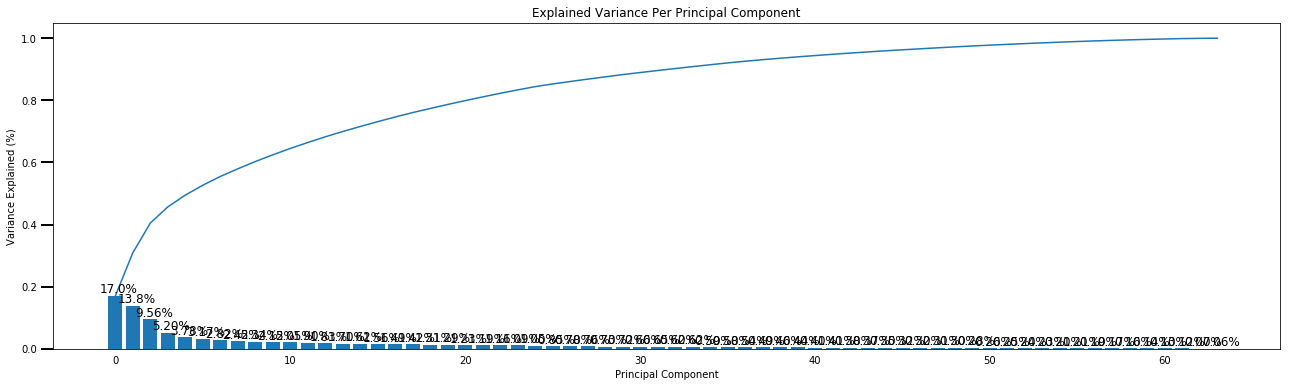

In [80]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_40 = PCA(n_components=40)
azdias_pca_40 = pca_40.fit_transform(azdias_ready_for_PCA)

### Discussion 2.2: Perform Dimensionality Reduction


The plot shows the variance explained falls alomost flat after 40 features and the cumulative explained variance almost becomes 1%. I feel going with 40 features will provide a good amount of variance for the model to come up with an effective targeting strategy.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [82]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_component_weights(pca, i):
    weight_map = {}
    for counter, feature in enumerate(azdias.columns):
        weight_map[feature] = pca.components_[i][counter]
    sorted_weights = sorted(weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_weights

pca_component_weights(pca_40,1)

[('ALTERSKATEGORIE_GROB', 0.25385286187962475),
 ('SEMIO_ERL', 0.22863663114324106),
 ('FINANZ_VORSORGER', 0.22255823819358778),
 ('SEMIO_LUST', 0.17857902454828345),
 ('RETOURTYP_BK_S', 0.1627047466723833),
 ('FINANZ_HAUSBAUER', 0.12374495615090947),
 ('SEMIO_KRIT', 0.11984642744005855),
 ('W_KEIT_KIND_HH', 0.11970214699914963),
 ('SEMIO_KAEM', 0.11223888572421339),
 ('PLZ8_ANTG3', 0.10392451431387476),
 ('EWDICHTE', 0.10000615301117491),
 ('PLZ8_ANTG4', 0.099612683508042116),
 ('ORTSGR_KLS9', 0.098857468296024278),
 ('ANREDE_KZ', 0.090071962892156576),
 ('FINANCIAL_STATUS', 0.082487486101662691),
 ('KBA05_ANTG4', 0.07798619405095919),
 ('ARBEIT', 0.072893867036296009),
 ('PLZ8_ANTG2', 0.070589496827641471),
 ('RELAT_AB', 0.069750029206025715),
 ('ANZ_HAUSHALTE_AKTIV', 0.068032224722344423),
 ('SEMIO_DOM', 0.067699813430944722),
 ('HH_EINKOMMEN_SCORE', 0.061166529935190547),
 ('WOHNDAUER_2008', 0.05536047317695697),
 ('FINANZ_MINIMALIST', 0.054082616965854147),
 ('KBA05_ANTG3', 0.0517

In [83]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_component_weights(pca_40,2)

[('SEMIO_VERT', 0.34815559626459347),
 ('SEMIO_SOZ', 0.26321005691530241),
 ('SEMIO_FAM', 0.25104619352684393),
 ('SEMIO_KULT', 0.23232855839248137),
 ('FINANZ_MINIMALIST', 0.15822223041200711),
 ('RETOURTYP_BK_S', 0.11595875948685111),
 ('FINANZ_VORSORGER', 0.099957632389055306),
 ('W_KEIT_KIND_HH', 0.093060207301023212),
 ('ALTERSKATEGORIE_GROB', 0.084153163831770475),
 ('SEMIO_REL', 0.079449133623857443),
 ('SEMIO_LUST', 0.075330576000882846),
 ('SEMIO_MAT', 0.052066019343701961),
 ('GREEN_AVANTGARDE', 0.049449226215700498),
 ('EWDICHTE', 0.044728376932449687),
 ('ORTSGR_KLS9', 0.044509028738972681),
 ('PLZ8_ANTG4', 0.042934953669738304),
 ('PLZ8_ANTG3', 0.042112215773690655),
 ('WOHNDAUER_2008', 0.035589845788089082),
 ('ARBEIT', 0.030369440269613222),
 ('RELAT_AB', 0.029031196448986531),
 ('PLZ8_ANTG2', 0.028369161271407952),
 ('KBA05_ANTG4', 0.028060054524712288),
 ('ANZ_HAUSHALTE_AKTIV', 0.025654566995450469),
 ('FINANCIAL_STATUS', 0.023714147997240427),
 ('VERS_TYP', 0.02180761

In [84]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_component_weights(pca_40,3)

[('GREEN_AVANTGARDE', 0.39392214693198718),
 ('EWDICHTE', 0.26279936975711848),
 ('ORTSGR_KLS9', 0.2475254836254942),
 ('PLZ8_HHZ', 0.15085840760989908),
 ('ONLINE_AFFINITAET', 0.13617345884945081),
 ('OST_WEST_KZ', 0.12217250707886539),
 ('SEMIO_DOM', 0.11666761943081254),
 ('PLZ8_ANTG2', 0.10595008392196806),
 ('ANZ_PERSONEN', 0.10078624373348945),
 ('PLZ8_ANTG3', 0.09763831628579521),
 ('KBA05_ANTG1', 0.094311781010074966),
 ('FINANZ_UNAUFFAELLIGER', 0.094229103735201436),
 ('RELAT_AB', 0.088453301467947748),
 ('PLZ8_ANTG4', 0.080888461215793808),
 ('SEMIO_KAEM', 0.076885510561602949),
 ('SEMIO_TRADV', 0.066461430035254787),
 ('KBA13_ANZAHL_PKW', 0.062689574932284761),
 ('FAMILY_TYPE', 0.062662889610085537),
 ('FINANZ_MINIMALIST', 0.062258688514516637),
 ('SEMIO_RAT', 0.058336143098011523),
 ('MOBI_REGIO', 0.056952676183233332),
 ('ANZ_TITEL', 0.052897249496336257),
 ('KBA05_GBZ', 0.046464591748081721),
 ('PLZ8_GBZ', 0.045836128705036491),
 ('ANZ_HH_TITEL', 0.043634707599833296),
 (

### Discussion 2.3: Interpret Principal Components

#### Feature 1:
##### First 5 Positves:
ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
SEMIO_ERL - personality, event-oriented
FINANZ_VORSORGER - financial topology (be prepared)
SEMIO_LUST - personality, sensual minded
RETOURTYP_BK_S - Returner type, likely or unlikely to return purchases

##### First 5 Negatives:
SEMIO_TRADV - personality, traditional minded
FINANZ_SPARER - financial topology - money saver
SEMIO_PFLICHT -  personality, dutiful
DECADE - newly engineered feature, year of birth - high -ve means older
SEMIO_REL - personality, religious 

This feature seems to focus on a group described via age, sensual and event oriented individuals who would like to be prepared financially for situations.  Older savers with tranditional and religious mindset might not be the popualtion to target.  

#### Feature 2:
##### First 5 Positves:
SEMIO_VERT - personality, dreamful
SEMIO_SOZ - personality, socially minded
SEMIO_FAM -personality, family minded
SEMIO_KULT -personality, cultural minded
FINANZ_MINIMALIST - Financial typology, low financial interest

##### First 5 Negatives:
ANREDE_KZ - gender
SEMIO_KAEM -personality, combative
SEMIO_DOM-personality, dominant minded
SEMIO_KRIT-personality, critical minded
SEMIO_RAT--personality, rational

This feature seems to target young people, who are hopeful with dreams, with social,family and cultural minded who are likely to be interested in saving. Gender doesn't seem to have an impact, neither poeple with strong personality.


#### Feature 3:
##### First 5 Positves:
GREEN_AVANTGARDE - Membership in environmental sustainability as part of youth
EWDICHTE - Density of households per square kilometer
ORTSGR_KLS9 - community size
PLZ8_HHZ - Number of households within the PLZ8 region
ONLINE_AFFINITAET - online affinity

##### First 5 Negatives:
MAINSTREAM_AVANTGARDE - newly engineered feature, movement related
KKK - purchasing power in region
HH_EINKOMMEN_SCORE - Estimated household net income
BALLRAUM - Distance to nearest urban center
INNENSTADT - Distance to city center (downtown)

This feature seems to idenify people who are green conscious, live in high density households in larger communites who are also active online. Low purchasing power and statying farther from the city seem to have a negative impact.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [85]:
#udacity function
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data)) #absolute value taken
    
    return score

In [35]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
centers = list(range(1,5))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca_40, center))
print("clustering done for 1-5")

clustering done for 1-5


In [36]:
centers = list(range(5,10))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca_40, center))
print("clustering done for 5-10")

clustering done for 5-10


In [37]:
centers = list(range(10,15))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca_40, center))
print("clustering done for 10-15")

clustering done for 10-15


In [38]:
centers = list(range(15,20))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca_40, center))
print("clustering done for 15-20")

clustering done for 15-20


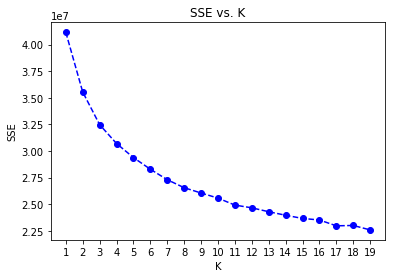

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
x = range(1, 20)
centers = list(range(1,20))
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(x)
plt.ylabel('SSE');
plt.title('SSE vs. K');    

In [86]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#going with 8 cluster counts
kmeans_8 = KMeans(n_clusters=8).fit(azdias_pca_40)

### Discussion 3.1: Apply Clustering to General Population

I couldn't see a sharp elbow bend as it was shown in the training project example. In this curve, the SSE seems to flatten between 7 and 8. So, I am going with 8 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [87]:
# Load in the customer demographics data.
customers = pd.read_csv ('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [88]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#pre process
customers_cleansed=clean_data(customers)
print('cleansed')

#feature transformation
customers_imputed = imputer.transform(customers_cleansed)
customers_imputed_df = pd.DataFrame(customers_imputed, columns = customers_cleansed.columns)
print('transformed')

#feaure scaling
customers_scaled = scaler.transform(customers_imputed)
customers_scaled_df = pd.DataFrame(customers_scaled, columns = customers_cleansed.columns)
print('scaled')

#dimensionality redcution
customers_pca_40 = pca_40.transform(customers_scaled_df)
print('dimension reduced')


#clustering prediction
kmeans = KMeans(n_clusters = 8).fit(customers_pca_40)
customers_predicted = kmeans.predict(customers_pca_40)
print('clustered')

cleansed
transformed
scaled
dimension reduced
clustered


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

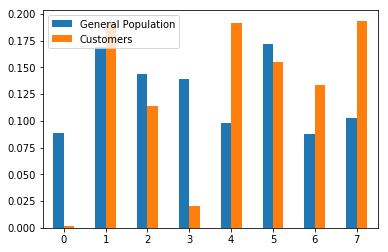

In [89]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#predict gen population
azdias_predicted = kmeans_8.predict(azdias_pca_40)

gen_pop_proportion_df = pd.DataFrame(data=azdias_predicted, columns=['flag'])['flag'].value_counts()/len(azdias_predicted)
customer_proportion_df = pd.DataFrame(data=customers_predicted, columns=['flag'])['flag'].value_counts()/len(customers_predicted)

# Plot the proportions
df = pd.DataFrame({'General Population': gen_pop_proportion_df,'Customers': customer_proportion_df})
df.plot.bar(rot=0)
plt.show()

GREEN_AVANTGARDE     0.944916
FINANZ_MINIMALIST    5.034022
SEMIO_VERT           6.221693
KBA05_ANTG1          2.916926
ANZ_PERSONEN         2.847859
Name: 7, dtype: float64


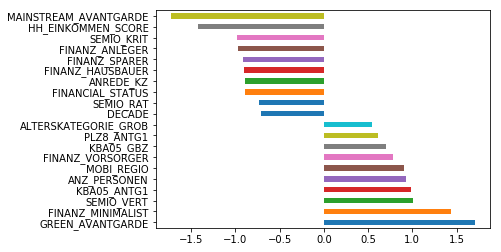

In [147]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

def plot_scaled_comparison(df_sample, kmeans, cluster): 
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns, pca_40.inverse_transform(
        kmeans.cluster_centers_[cluster]))), orient='index').rename( columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    #print actual values of top positive 5 features of this cluster
    cluster_feature_vals = pd.DataFrame(scaler.inverse_transform(pca_40.inverse_transform(kmeans.cluster_centers_)), columns=df_sample.columns)
    temp_df = pd.DataFrame(X).transpose()
    print(cluster_feature_vals.loc[cluster,temp_df.columns[:5]])
    
    X['feature_values_abs'] = abs(X['feature_values']) 
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');
    
    
    
    
#over represetend cluster 7
plot_scaled_comparison(azdias_ready_for_PCA, kmeans, 7)

SEMIO_ERL           6.550720
GREEN_AVANTGARDE    0.594749
ANREDE_KZ           1.942151
KBA05_ANTG1         2.729741
MOBI_REGIO          4.192533
Name: 4, dtype: float64


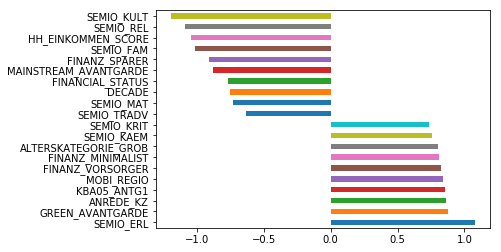

In [143]:
#over represetend cluster 4
plot_scaled_comparison(azdias_ready_for_PCA, kmeans, 4)

ANZ_HH_TITEL            10.185378
ANZ_HAUSHALTE_AKTIV    214.431199
KBA05_ANTG4              1.336797
FAMILY_TYPE              4.866055
FINANCIAL_STATUS         4.853573
Name: 0, dtype: float64


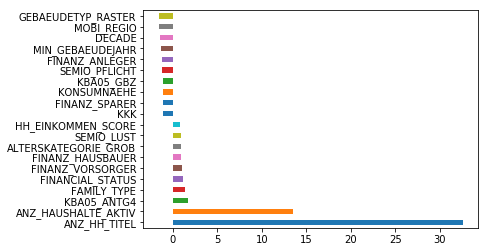

In [144]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#under represetend cluster 0
plot_scaled_comparison(azdias_ready_for_PCA, kmeans, 0)

ANZ_TITEL            1.079679
ANZ_HH_TITEL         1.074210
GREEN_AVANTGARDE     0.875761
FINANZ_MINIMALIST    4.533736
FINANZ_VORSORGER     4.767039
Name: 3, dtype: float64


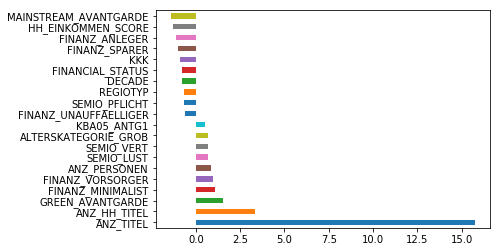

In [146]:
#under represetend cluster 3
plot_scaled_comparison(azdias_ready_for_PCA, kmeans, 3)

### Discussion 3.3: Compare Customer Data to Demographics Data

Proportion comparison shows clusters 4 and 7 are overrepresented in the customer data compared to the general population. Likewise clusters 0 and 3 are underrepresented in the customer data compared to the general population.


#### Overrepresented clusters
My observstions about the characteristics of people in that cluster are as follows:

###### Cluster 7
This represents people who have high financial interest, not dreamful belong to small family of adults that live in a community that has a high share of small family homes. These people are likely work towards environmental sustainablity. Probably represents youth who have just began their family life.


###### Cluster 4
This group consists of females who are not event oriented, not serious about environmental sustainability. They probably live in a community that has a high share of small family homes and they like to stay put.


#### Underrepresented clusters
My observstions about the characteristics of people in that cluster are as follows:

###### Cluster 0
People in the group belong to a community that is less affluent or poor, not well-educated (where about 5% that live in a high-rise building are professional academic holders) and has a low share of large family homes. This group probably represents older/mature/retired individuals/couples.

###### Cluster 3
People in the group belong to a community that is not well-educated (less professional academic account holders)and are not serious about environmental sustainability. They probably have very low financial interest and not interested in saving.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.